In [ ]:
!qbraid jobs enable amazon_braket

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

from braket.aws import AwsDevice
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from quera_ahs_utils.plotting import show_global_drive, show_register
from quera_ahs_utils.drive import get_drive 

from iquhack_utils import find_UDG_radius, visualize_graph, get_blockade_radius, get_graph_from_blockade_radius, C6, save_result_json, open_json

from utils import postprocess_MIS, analysis_MIS

In [2]:
plt.rcParams['figure.dpi'] = 140

In [3]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

C6 = float(capabilities.rydberg.dict()['c6Coefficient']) # rad m^6/sec

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [4]:
def square_lattice(num_rows, num_cols):
    points = []
    
    num_centers = num_rows * num_cols
    num_corners = (num_rows + 1) * (num_cols + 1)
    graph_connections = []
    
    # Build corners
    for row in range(num_rows + 1):
        for col in range(num_cols + 1):
            start = np.array([col, row])
            points.append(start)
            
    # Build centers
    curr_id = num_corners
    for row in range(num_rows):
        for col in range(num_cols):
            start = np.array([col, row])
            points.append(start + np.array([1/2, 1/2]))
            bottomleft_corner_id = row * (num_cols + 1) + col
            bottomright_corner_id = bottomleft_corner_id + 1
            topleft_corner_id = bottomleft_corner_id + num_cols + 1
            topright_corner_id = topleft_corner_id + 1
            graph_connections.append((topleft_corner_id, curr_id))
            graph_connections.append((topright_corner_id, curr_id))
            graph_connections.append((bottomleft_corner_id, curr_id))
            graph_connections.append((bottomright_corner_id, curr_id))
            curr_id = curr_id + 1
    
    centers = range(num_centers)
    corners = range(num_centers, num_centers + num_corners)
    
    graph = nx.Graph(graph_connections)
    
    return np.array(points), graph

In [5]:
def linear_chain(n_verts, direction):
    points = []
    for i in range(n_verts):
        if direction == 'HORIZ':
            points.append(np.array([i, 0]))
        if direction == 'VERT':
            points.append(np.array([0, i]))
        if direction == 'DIAG':
            points.append(np.array([i, i]) / np.sqrt(2)) 
            
    graph = nx.Graph([(i, i+1) for i in range(n_verts - 1)])
    return np.array(points), graph

In [ ]:
def lieb_lattice():
    points = []
    points.append(np.array([0, 0]))
    points.append(np.array([1, 0]))
    points.append(np.array([2, 0]))
    points.append(np.array([1, 1]))
    points.append(np.array([1, -1]))
    
    graph = nx.Graph()
    
    return np.array(points), graph

In [ ]:
points, graph = square_lattice(6, 7)
# points, graph = linear_chain(12, 'HORIZ')

# print(f"Points: {points}")
print(f"# Points: {len(points)}")
plt.scatter(*zip(*(points)))
plt.show()

print(f"Edges: {graph.edges}")
nx.draw(graph)

Unit Disk Radius: 1.4142135623730951
Minimum Radius: 1.0
Maximum Radius: 2.0


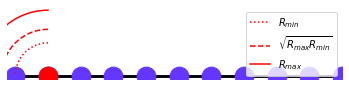

In [72]:
unitdisk_radius, min_radius, max_radius = find_UDG_radius(points, graph)
print(f"Unit Disk Radius: {unitdisk_radius}\nMinimum Radius: {min_radius}\nMaximum Radius: {max_radius}")

figure = plt.figure()
axes = plt.subplot(1,1,1)
visualize_graph(axes, graph, points)

x0, y0 = (1,0)
angles = np.linspace(np.pi/2,np.pi,1001)

axes.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
axes.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
axes.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

axes.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
axes.set_xlim((-0.25,10))

plt.legend(loc="upper right",)
plt.show()

Blockade Radius: 1.014e-05m
Unit Disk Radius: 7.203


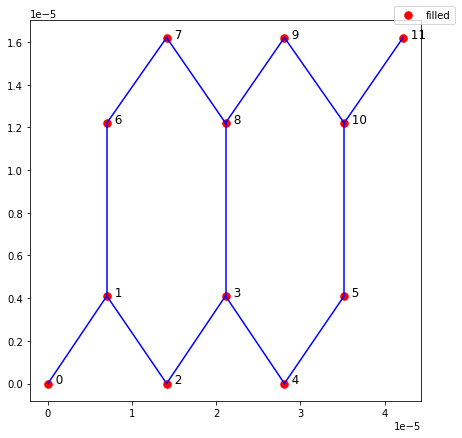

In [15]:
honey=  [(0.0, 0.0),
 (2.5, 1.4433756729740645),
 (5.0, 0.0),
 (7.5, 1.4433756729740645),
 (10.0, 0.0),
 (12.5, 1.4433756729740645),
 (2.5, 4.330127018922193),
 (5.0, 5.773502691896257),
 (7.5, 4.330127018922193),
 (10.0, 5.773502691896257),
 (12.5, 4.330127018922193),
 (15.0, 5.773502691896257)]
honey = [[pair[0]*2, pair[1]*2]for pair in honey]
#2.698
detuning_final = 5e6 # rad/sec
unitdisk_radius = 7.203
# Find blockade radius
blockade_radius = get_blockade_radius(detuning_final, 0) # no rabi amplitude at the end
print('Blockade Radius: {:0.3e}m'.format(blockade_radius))
print('Unit Disk Radius: {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius
# Generate the atom register
register = AtomArrangement()
for x in honey:
    register.add((a * np.array(x)).round(7))

# print(register)
show_register(register, blockade_radius = blockade_radius)

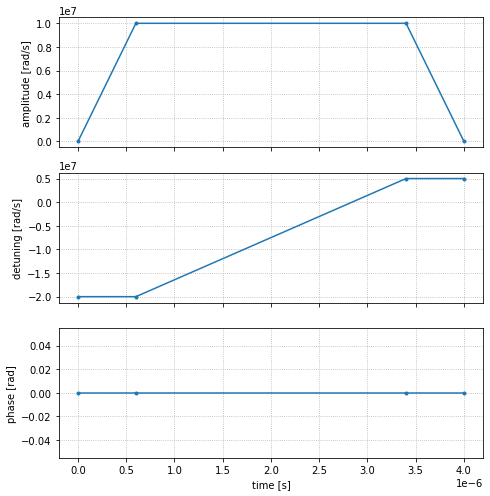

In [16]:
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
detuning_initial = -20e6     # rad / sec
detuning_final = detuning_final # Defined above

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_initial, detuning_initial, detuning_final, detuning_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [17]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

In [ ]:
raise BaseException("Only run this cell when you are ready to submit your job.")
if points.size > 12:
    raise BaseException(f"Are you sure you want to simulate a {len(points)}-vert graph?")
device = LocalSimulator("braket_ahs")
ahs_run = device.run(ahs_program, shots=1)

result  = ahs_run.result()
save_result_json("square_lattice_mis.json", result)

In [ ]:
raise BaseException("Only run this cell when you are ready to submit your job.")
#DO NOT RUN THIS UNLESS YOU ARE SURE
nshots = 100
task = qpu.run(ahs_program, shots=nshots)
print(task)

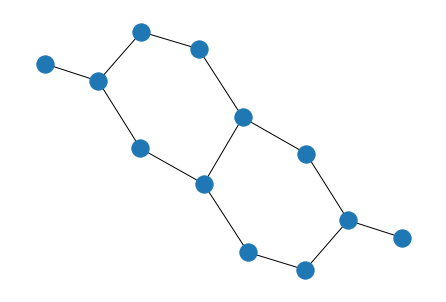

In [18]:
graph, _ = get_graph_from_blockade_radius(register, blockade_radius)
nx.draw(graph)

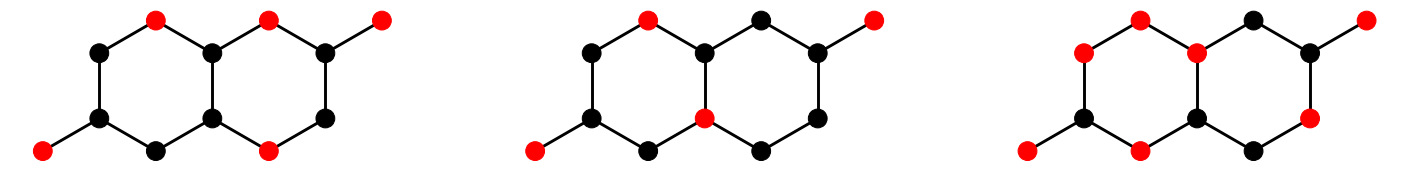

In [20]:
filename = "honeycomb_mis.json"
result_json = open_json(filename)
num_measurements = len(result_json["measurements"])
sequences = [result_json["measurements"][i]["post_sequence"] for i in [0,num_measurements-2,num_measurements-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[sequences[i][j]] for j in range(len(sequences[i]))]
    visualize_graph(ax, graph, np.array(honey), node_colors = seqs_color)
plt.show()

Average pre-processed size:  5.0000
Average post-processed IS size: 4.7556


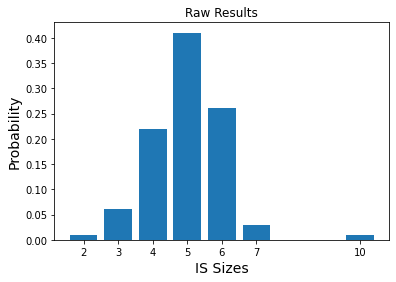

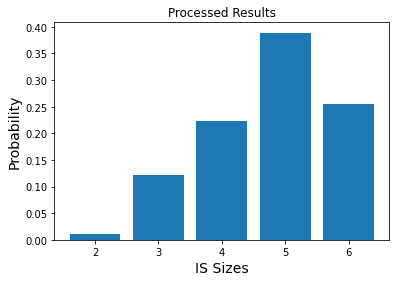

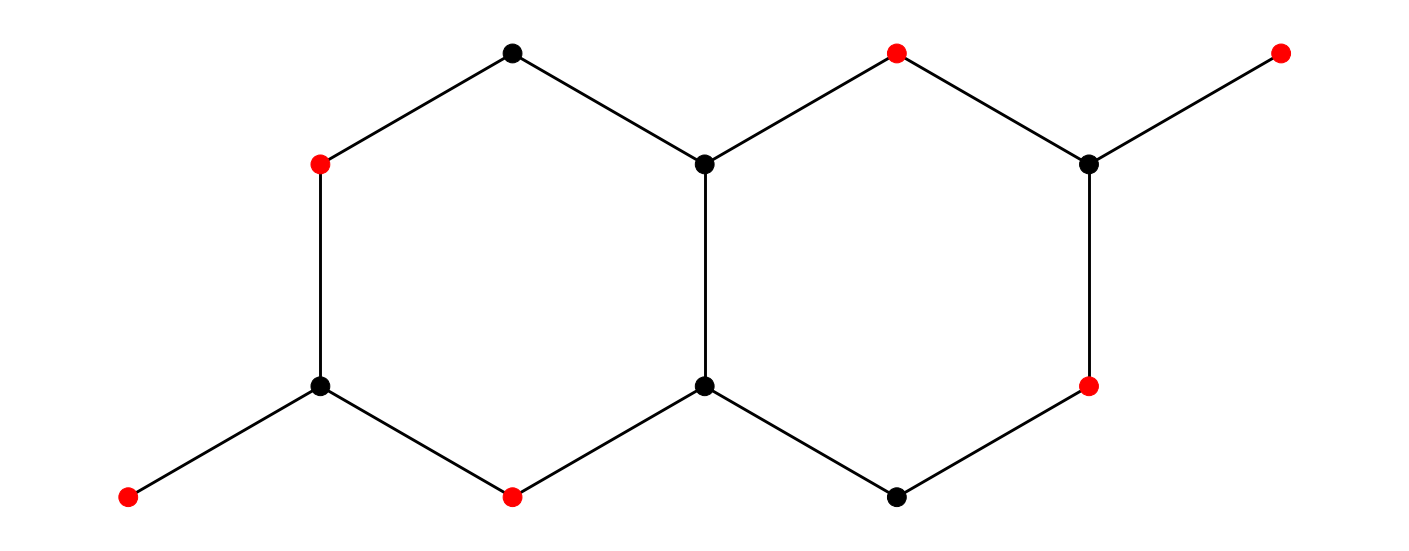

In [22]:
filename = "honeycomb_mis.json"
points = honey
result_json = open_json(filename)
IS_sizes,pp_bitstrings = analysis_MIS(graph, result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = min(len(ind),1)

figure = plt.figure(figsize=(25,15))
for i in range(n_show):
    axes = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(axes, graph, {a: points[a] for a in range(len(points))}, node_colors = seqs_color)
    
    # print(np.where(pp_bitstrings[ind[i]]==0)[0])
    # print(seqs_color)
    
plt.show()